## Applying `DCGAN` model on `Celeba` Dataset

In [1]:
#importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [ ]:
# Set random seed for reproducibility
manualSeed = 999
print("Seed: ", manualSeed)
torch.manual_seed(manualSeed)

# Configuration parameters for the DCGAN model
dataroot = "./data/celeba"   # Dataset root directory
image_size = 64 # Image size
batch_size = 128 # Batch size
workers = 2 # Number of dataloader workers
nz = 100 # Latent vector size
ngf = 64 # Generator feature map size
ndf = 64 # Discriminator feature map size
nc = 3  # Number of image channels (RGB)
num_epochs = 8 # Number of epochs
lr = 0.0002 # Learning rate
beta1 = 0.5 # Adam optimizer beta1

Seed:  999


In [ ]:
# Device configuration: use GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define image transformations
transform = transforms.Compose([
    transforms.CenterCrop(178),  # Center crop the images
    transforms.Resize(image_size),  # Resize images to the defined size
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Load the CelebA dataset
dataset = dset.CelebA(root=dataroot, split='train', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Initialize weights for the network
def weights_init(m):
    classname = m.__class__.__name__
    if "Conv" in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif "BatchNorm" in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=f035222d-2e27-4226-a0a0-a8e1212b02c6
To: /kaggle/working/data/celeba/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:12<00:00, 118MB/s] 
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /kaggle/working/data/celeba/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 88.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /kaggle/working/data/celeba/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 24.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /kaggle/working/data/celeba/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 30.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r

In [ ]:
# Define the Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # First layer
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Second layer
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Third layer
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Fourth layer
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Output layer
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, input):
        return self.main(input)




In [ ]:
# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # First layer
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Second layer
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Third layer
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Fourth layer
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Output layer
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output is a probability
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [ ]:
# Initialize the Generator and apply weights
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Initialize the Discriminator and apply weights
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

# Define the loss function
criterion = nn.BCELoss()

# Define optimizers for both Generator and Discriminator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Create fixed noise for generating images
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Lists to keep track of losses and generated images
G_losses = []
D_losses = []
img_list = []

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator with real images
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Update Discriminator with fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(0.)
        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Update Discriminator
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(1.)
        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Print training statistics every 50 batches
        if i % 50 == 0:
            print(f"[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}]\t"
                  f"Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\t"
                  f"D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")

    # Save generated images after each epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    os.makedirs("results", exist_ok=True)
    vutils.save_image(fake, f"results/fake_samples_epoch_{epoch+1}.png", normalize=True)

print("Training complete!")


Starting Training Loop...
[1/8][0/1272]	Loss_D: 1.5943	Loss_G: 5.4803	D(x): 0.5768	D(G(z)): 0.5501/0.0069
[1/8][50/1272]	Loss_D: 0.1206	Loss_G: 5.8418	D(x): 0.9508	D(G(z)): 0.0457/0.0060
[1/8][100/1272]	Loss_D: 0.3357	Loss_G: 9.3400	D(x): 0.9323	D(G(z)): 0.1442/0.0002
[1/8][150/1272]	Loss_D: 0.4783	Loss_G: 3.3596	D(x): 0.7683	D(G(z)): 0.0762/0.0518
[1/8][200/1272]	Loss_D: 0.2524	Loss_G: 3.0662	D(x): 0.8720	D(G(z)): 0.0633/0.1073
[1/8][250/1272]	Loss_D: 0.4257	Loss_G: 4.6373	D(x): 0.7589	D(G(z)): 0.0518/0.0196
[1/8][300/1272]	Loss_D: 0.4326	Loss_G: 4.1542	D(x): 0.7303	D(G(z)): 0.0303/0.0269
[1/8][350/1272]	Loss_D: 0.3429	Loss_G: 3.9342	D(x): 0.8214	D(G(z)): 0.0926/0.0340
[1/8][400/1272]	Loss_D: 0.4190	Loss_G: 4.4508	D(x): 0.8027	D(G(z)): 0.1295/0.0199
[1/8][450/1272]	Loss_D: 0.5733	Loss_G: 5.4168	D(x): 0.8851	D(G(z)): 0.3123/0.0087
[1/8][500/1272]	Loss_D: 0.5854	Loss_G: 4.5433	D(x): 0.7690	D(G(z)): 0.1594/0.0220
[1/8][550/1272]	Loss_D: 0.4705	Loss_G: 4.7646	D(x): 0.7235	D(G(z)): 0.0245/

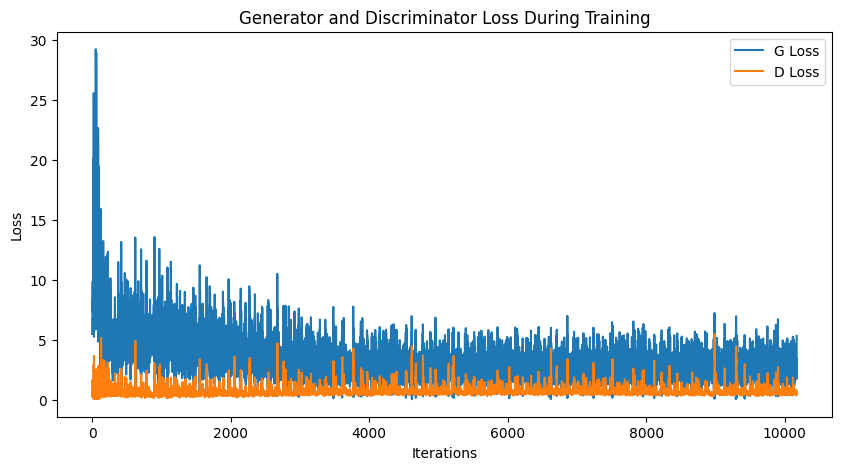

In [ ]:
#plotting the respective loss
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G Loss")
plt.plot(D_losses, label="D Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#displaying the output
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

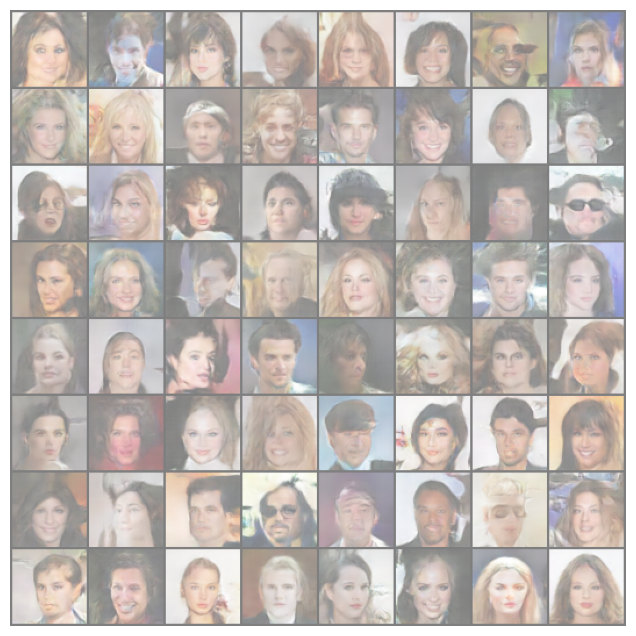

In [ ]:
imshow(img_list[-1])